## Fastai CNN examples
Make sure to point the symbolic link "fasiai" to the fastai library

## Problem
https://www.hackerearth.com/problem/machine-learning/predict-the-energy-used-612632a9-9de79188/


In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "data/identifytheanimal/"
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
#assign GPU device
torch.cuda.set_device(0)

True
True


In [4]:
print(os.listdir(f'{PATH}'))
samplefiles=os.listdir(f'{PATH}train')[:5]
samplefiles

['test.csv', 'test', 'train', 'sample_submission.csv', 'train.csv']


['Img-444.jpg', 'Img-718.jpg', 'Img-6978.jpg', 'Img-7545.jpg', 'Img-667.jpg']

(768, 1024, 3)


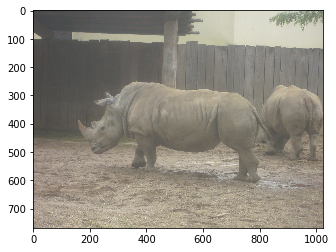

In [5]:
img = plt.imread(f'{PATH}train/{samplefiles[1]}')
plt.imshow(img)
print(img.shape)

In [6]:
#data
print(len(os.listdir(f'{PATH}train')))
print(len(os.listdir(f'{PATH}test')))

13000
6000


## Create validation set

In [7]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set
print('total: %s   cv: %s ' % (n,len(val_idxs)))

total: 13000   cv: 2600 


## Initial data exploration

In [10]:
pd.options.display.max_rows=999
label_df = pd.read_csv(label_csv)
label_df.pivot_table(index="Animal", aggfunc=len).sort_values('Image_id', ascending=False)

,Image_id
Animal,
horse,1111
squirrel,808
antelope,695
german+shepherd,687
collie,680
seal,665
buffalo,606
grizzly+bear,583
otter,519


In [11]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


In [12]:
sz=224
bs=58
#arch=resnet34
arch = resnext101_64
data = get_data(sz, bs)

(array([  15.,  301., 1192., 1495.,  402., 6957.,    8.,    1.,    3.,   26.]),
 array([ 100.,  282.,  464.,  646.,  828., 1010., 1192., 1374., 1556., 1738., 1920.]),
 <a list of 10 Patch objects>)

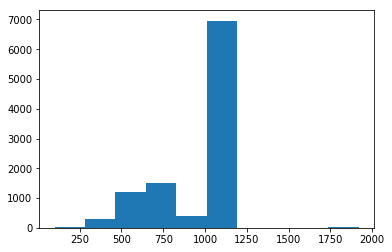

In [13]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
plt.hist(row_sz)

(array([   4.,   11.,  180.,  132.,  974.,  215.,  737.,  769.,  108., 7232.]),
 array([ 100. ,  192.4,  284.8,  377.2,  469.6,  562. ,  654.4,  746.8,  839.2,  931.6, 1024. ]),
 <a list of 10 Patch objects>)

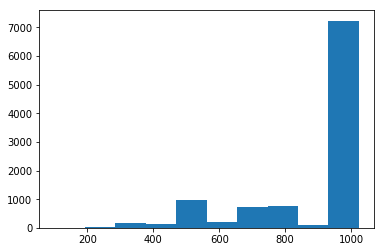

In [14]:
plt.hist(row_sz[row_sz<1200])

(array([   8.,   40.,  426.,  573.,  533.,  604., 3788., 2567.,  262.,  110.]),
 array([100. , 189.8, 279.6, 369.4, 459.2, 549. , 638.8, 728.6, 818.4, 908.2, 998. ]),
 <a list of 10 Patch objects>)

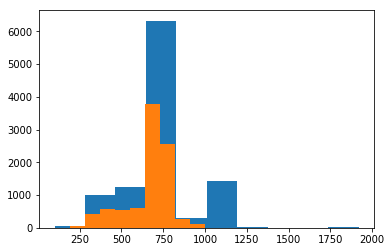

In [16]:
plt.hist(col_sz)
plt.hist(col_sz[col_sz<1000])

In [17]:
len(data.classes), data.classes[:5]

(30, ['antelope', 'bat', 'beaver', 'bobcat', 'buffalo'])

## Steps to build world class imageclassifier
1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting



## Quick model:
1. No data augumentation. Use precompute=True to keep all weights except the last layer
2. Use LR finder to get the learning rate
3. Get a quick result for training/validation loss and accuracy

100%|██████████| 104/104 [00:40<00:00,  2.57it/s]


 91%|█████████ | 164/180 [00:00<00:00, 188.13it/s, loss=3.38]


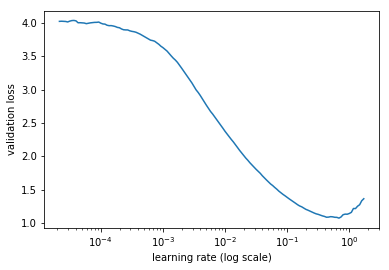

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
learn.sched.plot()

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [31]:
learn.fit(0.001, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.733928   0.398373   0.911923  
    1      0.420585   0.276282   0.931154                     
    2      0.328504   0.232577   0.935769                     



[array([0.23258]), 0.9357692395265286]

## Data augumentation

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(0.001, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.987066   0.488546   0.903077  
    1      0.525733   0.32792    0.924231                     
    2      0.407241   0.266652   0.931538                     
    3      0.362307   0.237932   0.935                        
    4      0.310935   0.217036   0.938846                     



[array([0.21704]), 0.9388461562761894]

epoch      trn_loss   val_loss   accuracy                    
    0      0.335615   0.211303   0.942308  
    1      0.332123   0.205458   0.938462                    
    2      0.323018   0.200985   0.943462                    
    3      0.301175   0.192574   0.946154                    
    4      0.300676   0.190117   0.944615                    



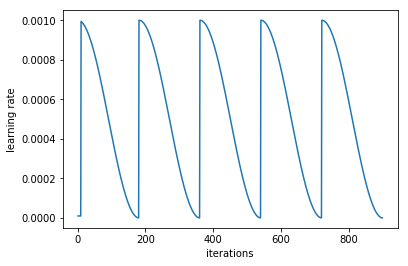

In [33]:
## unfreeze the layers and retrain
learn.precompute=False
learn.fit(0.001, 5, cycle_len=1)
learn.sched.plot_lr()

In [34]:
## increase size: Starting training on small images for a few epochs, then switching to bigger images, 
## and continuing training is an amazingly effective way to avoid overfitting.
learn.set_data(get_data(299, bs)) 
learn.freeze()
learn.fit(0.001, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.271433   0.175477   0.946923  
    1      0.256178   0.171717   0.949615                    
    2      0.247606   0.167068   0.951923                    



[array([0.16707]), 0.9519230784361179]

In [35]:
## When you are under fitting, it means cycle_len=1 is too short 
## (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(0.001, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.23414    0.16558    0.950385  
    1      0.242256   0.157363   0.953462                    
    2      0.228944   0.159903   0.953846                    
    3      0.232897   0.155183   0.952308                    
    4      0.223986   0.148181   0.958077                    
    5      0.219171   0.149666   0.957692                    
    6      0.225043   0.148774   0.957308                    



[array([0.14877]), 0.9573076927203399]

In [36]:
# TTA (test time data augumentation)  -- use validation dataset
from sklearn import metrics
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9561538461538461, 0.1495824157613968)

In [53]:
learn.fit(0.001, 3, cycle_len=2, cycle_mult=2) # 7 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.195933   0.146441   0.957308  
    1      0.216566   0.147978   0.955                       
    2      0.20555    0.144535   0.956923                    
    3      0.186297   0.142286   0.958846                    
    4      0.202119   0.140206   0.957692                    
    5      0.210748   0.142756   0.959231                    
    6      0.199105   0.138361   0.96                        
    7      0.190442   0.137109   0.957692                    
    8      0.182368   0.138851   0.958077                    
    9      0.176233   0.135469   0.958462                    
    10     0.169552   0.136013   0.958846                    
    11     0.176764   0.134312   0.960385                    
    12     0.179265   0.13427    0.96                        
    13     0.16808    0.135866   0.958846                    



[array([0.13587]), 0.9588461577433807]

In [54]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9603846153846154, 0.1324273471564792)

## Create data for submission

In [62]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
probs.shape 

(6000, 30)

In [65]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'image_id', [o[5:] for o in data.test_ds.fnames])
df.insert(1, 'id', [int(o[9:-4]) for o in data.test_ds.fnames])

In [69]:
df

,image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
201,Img-1.jpg,1.274100e-05,3.289455e-06,1.350881e-05,8.687570e-05,9.986122e-01,2.885727e-06,7.927652e-06,5.907920e-06,1.444751e-05,...,2.595529e-06,1.963714e-06,6.256682e-05,1.547837e-06,7.004693e-06,3.582537e-06,4.597389e-06,5.500758e-06,1.323645e-06,2.260924e-06
2849,Img-2.jpg,6.425498e-03,9.346807e-04,1.355085e-03,2.175250e-02,7.238428e-04,2.595391e-03,1.828830e-03,1.947991e-03,1.668755e-03,...,4.986908e-02,1.106987e-02,1.594681e-02,1.202234e-02,7.031600e-01,1.681782e-03,1.861185e-02,3.578784e-03,3.634491e-03,5.054989e-03
5848,Img-3.jpg,3.191315e-04,4.147524e-05,1.008706e-04,1.163018e-04,2.305741e-03,2.042123e-05,2.850654e-05,4.105609e-06,4.761238e-05,...,2.517671e-04,2.805186e-05,7.395115e-01,4.996319e-05,2.068258e-05,8.065892e-06,4.236609e-05,8.735016e-05,2.025434e-05,1.679285e-03
2771,Img-4.jpg,1.006060e-05,2.283925e-04,1.888931e-05,2.184700e-06,1.715906e-05,1.988743e-05,1.802639e-05,2.601035e-06,4.894601e-06,...,9.945608e-01,5.675959e-05,9.701383e-06,3.537270e-05,4.346887e-05,4.062973e-05,1.109833e-04,6.669247e-06,4.346423e-03,1.211668e-04
3029,Img-5.jpg,2.124814e-05,7.141553e-04,1.969056e-04,1.710418e-05,6.954132e-06,7.920656e-04,1.352062e-03,1.775596e-04,1.835096e-04,...,2.932637e-03,6.041819e-01,4.713732e-06,1.353996e-04,8.804786e-05,1.163778e-04,1.699976e-04,1.386703e-04,1.060723e-02,6.734104e-06
3222,Img-6.jpg,2.197935e-06,2.000454e-06,2.857459e-05,7.249011e-07,1.614221e-04,3.670200e-07,3.437751e-06,5.004066e-07,1.154781e-06,...,3.523664e-06,4.652356e-06,2.950062e-06,9.955540e-01,6.840447e-06,6.076020e-06,3.038500e-06,3.892931e-03,2.231705e-05,3.647606e-06
1140,Img-7.jpg,1.180046e-02,1.342782e-04,7.010462e-05,1.369053e-04,1.147959e-04,2.076304e-05,3.217883e-05,2.493620e-05,2.891557e-05,...,2.950911e-05,1.870042e-05,1.302344e-04,2.547663e-05,6.086433e-06,8.755571e-05,2.585825e-05,7.870151e-06,1.286810e-05,5.072133e-04
1379,Img-8.jpg,2.277324e-04,7.572173e-05,4.291817e-05,6.176143e-06,1.781240e-05,5.637875e-06,1.924187e-05,7.957618e-06,2.727064e-05,...,2.293710e-06,7.675879e-06,2.900088e-03,1.955224e-05,1.282986e-05,9.492051e-06,5.104223e-06,3.487329e-05,2.517855e-06,1.127859e-05
4713,Img-9.jpg,1.346362e-04,4.822207e-04,2.346310e-04,1.130509e-04,9.945386e-01,9.408291e-06,6.899318e-05,1.429268e-05,1.013187e-05,...,1.675608e-04,5.332222e-05,4.498574e-04,1.651479e-05,5.428039e-05,9.980238e-05,6.333757e-05,6.491020e-05,6.437385e-05,6.748460e-06
5166,Img-10.jpg,1.038955e-05,5.099817e-06,4.257545e-06,5.646105e-06,9.366146e-06,2.305038e-05,6.604647e-06,2.350247e-05,9.996487e-01,...,3.690446e-06,2.096280e-05,9.626476e-06,7.928326e-05,3.263148e-06,5.950155e-06,2.279955e-06,2.643338e-06,1.287362e-05,6.217349e-06


In [68]:
df.sort_values(['id'],ascending=True,inplace=True)
df.drop(['id'],axis=1,inplace=True)

In [70]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.csv', index=False)
FileLink(f'{SUBM}subm.csv')

/home/chihchungwang/Documents/git/github/chwang733/fastai-examples/data/identifytheanimal/subm/subm.csv

## Predict individual image

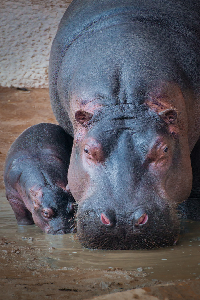

In [81]:
fn = data.val_ds.fnames[0]
Image.open(PATH + fn).resize((200,300))

In [82]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
display(np.argmax(preds))
learn.data.classes[np.argmax(preds)]

11

'hippopotamus'